In [2]:
import numpy as np

In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [5]:
import torch.nn.functional as F
import torch.optim as optim

In [6]:
from torch.autograd import Variable

In [7]:
folder = './data'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((32, 32))])

In [8]:
# Download MNIST dataset
train_set = dset.MNIST(root=folder, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=folder, train=False, transform=trans, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
def get_data(train_size, test_size):
    train_data = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=train_size,
                 shuffle=True)
    test_data = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=test_size,
                shuffle=True)
    return (train_data, test_data)

In [12]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        
        self.c1 = nn.Conv2d(1, 6, 5)
        self.c2 = nn.Conv2d(6, 16, 5)
        self.l1 = nn.Linear(16 * 5 * 5, 120)
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), 2)
        x = F.max_pool2d(F.relu(self.c2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        
        return x

In [13]:
def train_model(model, loss_func, epoch, data, optimizer):
    average_loss = 0
    sample_size = 0
    correct_predictions = 0
    total_loss = 0
    i=0
    for batch_idx, (x, target) in enumerate(data):
        i+=1
        optimizer.zero_grad()
        x, expected_out = Variable(x), Variable(target)
        output = model(x)
        loss = loss_func(output, expected_out)
        loss.backward()
        optimizer.step()
        predicted_output = np.argmax(output.data, axis=1)
        
        sample_size = sample_size + target.size(0)
        correct_predictions = correct_predictions + (predicted_output == expected_out).sum().item()
        accuracy = 100.0 * correct_predictions / sample_size
        total_loss = total_loss + loss.data
        
#         average_loss = average_loss * 0.9 + loss.data[0] * 0.1
        if (batch_idx+1) % 150 == 0 or (batch_idx+1) == len(data):
            print('Epoch: {}, batch index: {}, accuracy: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, round(accuracy, 2), loss.data))

    total_loss = total_loss/i;
    return total_loss, round(accuracy,2)

In [14]:
train_data, test_data = get_data(64, 1000)
model = Model_1()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
loss_arr = []
accuracy_arr = []

for epoch in range(1, 11):
    loss, accuracy = train_model(model, loss_func, epoch, train_data, optimizer)
    loss_arr.append(loss)
    accuracy_arr.append(accuracy)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 1, batch index: 150, accuracy: 64.39, train loss: 0.170067
Epoch: 1, batch index: 300, accuracy: 78.67, train loss: 0.149482
Epoch: 1, batch index: 450, accuracy: 84.43, train loss: 0.196906
Epoch: 1, batch index: 600, accuracy: 87.44, train loss: 0.087489
Epoch: 1, batch index: 750, accuracy: 89.34, train loss: 0.031479
Epoch: 1, batch index: 900, accuracy: 90.59, train loss: 0.070145
Epoch: 1, batch index: 938, accuracy: 90.86, train loss: 0.174497
Epoch: 2, batch index: 150, accuracy: 97.98, train loss: 0.075003
Epoch: 2, batch index: 300, accuracy: 97.89, train loss: 0.032112
Epoch: 2, batch index: 450, accuracy: 97.93, train loss: 0.065886
Epoch: 2, batch index: 600, accuracy: 97.96, train loss: 0.051232
Epoch: 2, batch index: 750, accuracy: 97.97, train loss: 0.048054
Epoch: 2, batch index: 900, accuracy: 98.02, train loss: 0.057118
Epoch: 2, batch index: 938, accuracy: 98.02, train loss: 0.081979
Epoch: 3, batch index: 150, accuracy: 98.59, train loss: 0.058410
Epoch: 3, 

<h3> Accuracy Plot <h3>

In [18]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.c1 = nn.Conv2d(1, 32, 5)
        self.c2 = nn.Conv2d(32, 64, 5)
        self.c3 = nn.Conv2d(64, 64, 5)
        self.l1 = nn.Linear(1024, 256)
        self.l2 = nn.Linear(256, 10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(F.max_pool2d(self.c2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.c3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.l1(x))
        x = F.dropout(x, training=self.training)
        x = self.l2(x)
        return F.log_softmax(x, dim=1)

In [19]:
train_data, test_data = get_data(64, 1000)
model = Model_2()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
loss_arr_2 = []
accuracy_arr_2 = []

for epoch in range(1, 11):
    print('New epoch')
    loss, accuracy = train_model(model, loss_func, epoch, train_data, optimizer)
    loss_arr_2.append(loss)
    accuracy_arr_2.append(accuracy)

New epoch
Epoch: 1, batch index: 150, accuracy: 63.67, train loss: 0.459141
Epoch: 1, batch index: 300, accuracy: 77.32, train loss: 0.268910
Epoch: 1, batch index: 450, accuracy: 83.04, train loss: 0.257445
Epoch: 1, batch index: 600, accuracy: 86.15, train loss: 0.079989
Epoch: 1, batch index: 750, accuracy: 88.15, train loss: 0.102282
Epoch: 1, batch index: 900, accuracy: 89.55, train loss: 0.093631
Epoch: 1, batch index: 938, accuracy: 89.82, train loss: 0.048061
New epoch
Epoch: 2, batch index: 150, accuracy: 96.93, train loss: 0.056571
Epoch: 2, batch index: 300, accuracy: 97.15, train loss: 0.081220
Epoch: 2, batch index: 450, accuracy: 97.17, train loss: 0.150319
Epoch: 2, batch index: 600, accuracy: 97.2, train loss: 0.197142
Epoch: 2, batch index: 750, accuracy: 97.2, train loss: 0.042226
Epoch: 2, batch index: 900, accuracy: 97.19, train loss: 0.118470
Epoch: 2, batch index: 938, accuracy: 97.18, train loss: 0.105202
New epoch
Epoch: 3, batch index: 150, accuracy: 97.62, tra

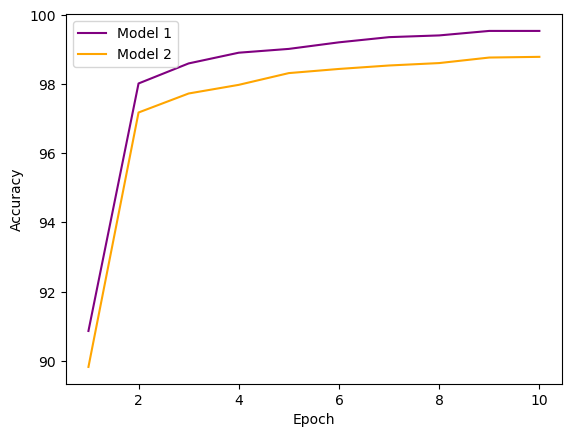

In [30]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(np.arange(1,11,1), accuracy_arr, color = "purple")
plt.plot(np.arange(1,11,1), accuracy_arr_2, color = "orange")
plt.legend(['Model 1', 'Model 2'])
plt.show()

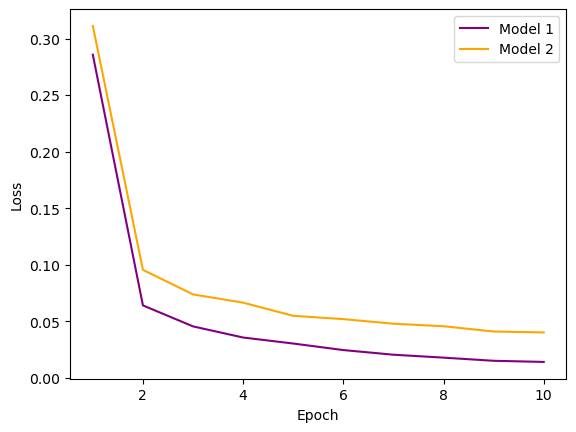

In [29]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(np.arange(1,11,1), loss_arr, color = "purple")
plt.plot(np.arange(1,11,1), loss_arr_2, color = "orange")
plt.legend(['Model 1', 'Model 2'])
plt.show()